In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import plotly.graph_objects as go


def get_fng():
	
	limit = 10000
	url = f'https://api.alternative.me/fng/?limit={limit}'

	# Realizar la solicitud GET
	response = requests.get(url)
	if response.status_code == 200:
		# Parsear el JSON
		json_data = response.json()

		# Extraer los datos que necesitas
		data = json_data['data']

		# Transformar a DataFrame
		df = pd.DataFrame(data)

		# Convertir el timestamp a formato datetime y agregarlo como columna
		df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
		df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
		# Seleccionar solo las columnas necesarias
		df = df[['datetime', 'value']]
		df.rename(columns={'value':'fng'},inplace=True)

		df['fng'] = df['fng'].astype(int)

		return df
	else:
		print(f"Error al realizar la solicitud: {response.status_code}")
		return False


def get_btc(df):
	# Fecha mínima de la API
	start_date = df['datetime'].min()
	end_date = datetime.now().strftime('%Y-%m-%d')

	# Descargar datos históricos de Bitcoin
	btc = yf.download("BTC-USD", start=start_date, end=end_date, interval="1d")

	# Convertir a DataFrame y formatear
	btc.reset_index(inplace=True)
	btc.rename(columns={"Date": "datetime", "Close": "BTC"}, inplace=True)
	btc = btc[["datetime", "BTC"]]
	btc.loc[:, 'datetime'] = pd.to_datetime(btc['datetime'], unit='s')
	
	# Unir con el DataFrame original
	merged_df = pd.merge(df, btc, on='datetime', how='left')

	return merged_df

def map(x, in_min, in_max, out_min, out_max):
	res = (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min
	if res>out_max:
		res = out_max
	elif res<out_min:
		res = out_min
	return res

In [2]:
df = get_fng()
df = get_btc(df)
df = df.sort_values(by='datetime')
df = df.dropna()
df = df.reset_index(drop=True)

# Calcular la media móvil de 50 días
df['fng_ma_s'] = df['fng'].rolling(window=21).mean()
#df['fng_ma_f'] = df['fng'].ewm(span=5).mean()
df['fng_ma_f'] = df['fng'].rolling(window=5).mean()

#Separa los valores del indice en diferentes stages: -2 Mucho Fear, +2 Mucho Greed
bins_range = [-1, 30, 49, 51, 70, 100]
labels_range = [-2, -1, 0, 1, 2]
df['stage'] = pd.cut(
	df['fng'],
	bins=bins_range,
	labels=labels_range,
	right=True
).astype(int)

df['fng_ma_s'] = df['fng_ma_s'].fillna(50)
df['fng_ma_f'] = df['fng_ma_f'].fillna(50)

df['stage_s'] = pd.cut(
	df['fng_ma_s'],
	bins=bins_range,
	labels=labels_range,
	right=True
).astype(int)
df['stage_f'] = pd.cut(
	df['fng_ma_f'],
	bins=bins_range,
	labels=labels_range,
	right=True
).astype(int)

[*********************100%%**********************]  1 of 1 completed


In [3]:

# Crear la figura
fig = go.Figure()

# Graficar BTC con un gradiente de color basado en FNG
fig.add_trace(
	go.Scatter(
		x=df['datetime'], 
		y=df['BTC'], 
		mode='lines+markers', 
		marker=dict(
			color=df['fng'],  # Usar FNG para el color
			colorscale='RdYlGn',  # Mapa de colores: de rojo a verde
			colorbar=dict(title="Fear and Greed Index"),  # Leyenda de color
			size=2,  # Tamaño de los puntos
			showscale=True  # Mostrar la escala de colores
		),
		line=dict(color='#ffffff'),
		name='BTC Price'
	)
)

# Configurar el diseño del gráfico
fig.update_layout(
	title="Bitcoin Price with FNG-based Color Gradient",
	xaxis=dict(title='Date'),
	yaxis=dict(title='Bitcoin Price (USD)'),
	legend=dict(x=0.01, y=0.99),  # Posición de la leyenda
)

# Mostrar el gráfico
fig.show()

Estrategia 1

In [4]:
cash = df['BTC'].loc[0]
wallet = cash
quote = wallet
base = 0.0
df['quote'] = None
df['base']  = None
df['buy'] = None
df['sell'] = None
threshold = 5
start = False

df['BTC_ma_s'] = df['BTC'].rolling(window=400).mean()
df['BTC_ma_f'] = df['BTC'].rolling(window=100).mean()

for i,row in df.iterrows():
	oper = 0
	to_hold_perc = map(row['fng_ma_s'],80,15,20,100)
	buyed_usd = base*row['BTC']
	to_hold_usd = wallet*(to_hold_perc/100)
	
	#Si estoy holdeando mas de lo que indica F&G -> vender
	if row['BTC']>row['BTC_ma_f'] and row['BTC']>row['BTC_ma_s'] and row['stage']==1 and row['stage_f']==1 and row['stage_s']==2 and buyed_usd > to_hold_usd*(1+threshold/100):
		to_sell_usd = buyed_usd - to_hold_usd
		to_sell_base = to_sell_usd/row['BTC']
		if base>=to_sell_base:
			base -= to_sell_base
			quote += to_sell_usd
			oper = -1
		
	#Si estoy holdeando menos de lo que indica F&G -> comprar
	if row['BTC']<row['BTC_ma_f'] and row['BTC']<row['BTC_ma_s'] and row['stage']==-1 and row['stage_f']==-1 and row['stage_s']==-2 and buyed_usd < to_hold_usd*(1-threshold/100):
		to_buy_usd = to_hold_usd - buyed_usd
		if quote>=to_buy_usd:
			base += to_buy_usd/row['BTC']
			quote -= to_buy_usd
			oper = 1

	
	df.at[i,'base'] = base
	df.at[i,'quote'] = quote
	if oper > 0:
		df.at[i,'buy'] = row['BTC']
	elif oper < 0:
		df.at[i,'sell'] = row['BTC']    


df['wallet'] = df['quote'] + df['base']*df['BTC']
days = df['datetime'].count()
pnl_month = (((df['wallet'].iloc[-1]-df['wallet'].iloc[0])/days)*30) / df['wallet'].iloc[0]
print('Days',days,'BUY',df[df['buy']>0]['buy'].count(),'SELL',df[df['sell']>0]['sell'].count())
print('PNL x Month',round(pnl_month*100,2))

# Crear la figura
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['datetime'], y=df['BTC'], mode='lines', line=dict(color='black'),name='BTC Price'))
fig.add_trace(go.Scatter(x=df['datetime'], y=df['BTC_ma_s'], mode='lines', line=dict(color='white'),name='BTC MA s'))
fig.add_trace(go.Scatter(x=df['datetime'], y=df['BTC_ma_f'], mode='lines', line=dict(color='gray'),name='BTC MA f'))
fig.add_trace(go.Scatter(x=df['datetime'], y=df['wallet'], mode='lines', line=dict(color='green'),name='Wallet'))
fig.add_trace(go.Scatter(x=df['datetime'], y=df['buy'], mode='markers', line=dict(color='#00ff00'),name='BUY'))
fig.add_trace(go.Scatter(x=df['datetime'], y=df['sell'], mode='markers', line=dict(color='#ff0000'),name='SELL'))
fig.update_layout(title="F&G Strategy",xaxis=dict(title='Date'),yaxis=dict(title='USD'),legend=dict(x=0.01, y=0.99),)
fig.show()

# Crear la figura
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['datetime'], y=(df['base']*df['BTC']), mode='lines', line=dict(color='gray'),name='BTC Hold'))
fig.add_trace(go.Scatter(x=df['datetime'], y=df['quote'], mode='lines', line=dict(color='green'),name='Quote Hold'))
fig.update_layout(title="F&G Strategy",xaxis=dict(title='Date'),yaxis=dict(title='USD'),legend=dict(x=0.01, y=0.99),)
fig.show()

Days 2555 BUY 4 SELL 5
PNL x Month 4.48


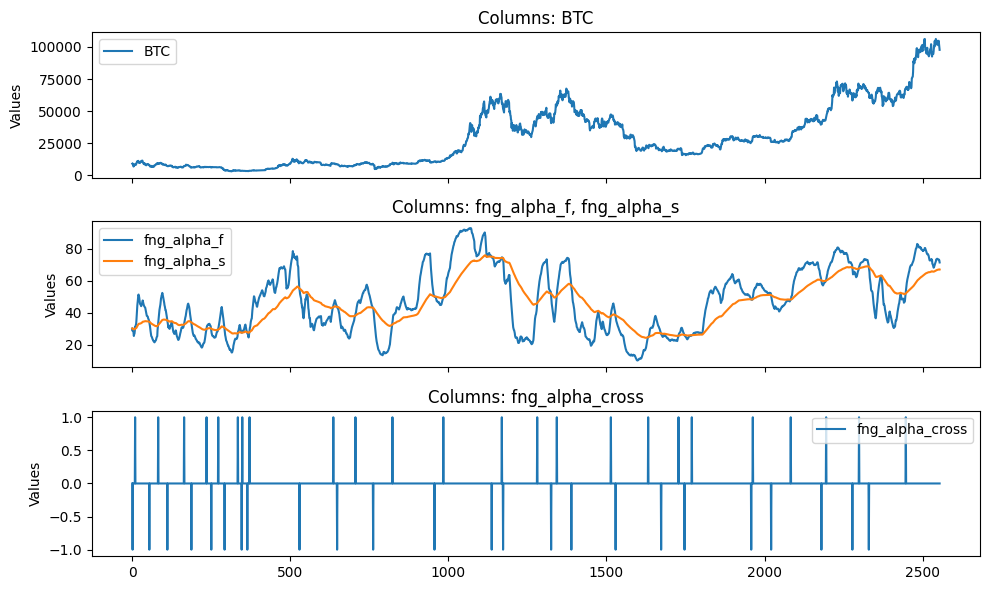

In [5]:
import matplotlib.pyplot as plt
#df[['BTC','fng','fng_ma_s','fng_ma_f']].plot(subplots=True,figsize=(20,10))
df['fng_alpha_f'] = df['fng'].ewm(alpha=0.1, adjust=False).mean()
df['fng_alpha_s'] = df['fng'].ewm(alpha=0.01, adjust=False).mean()

df['fng_alpha_cross']  = np.where( (df['fng_alpha_f'] > df['fng_alpha_s']) & (df['fng_alpha_f'].shift(1) <= df['fng_alpha_s'].shift(1)) , 1 , 0 )
df['fng_alpha_cross'] = np.where( (df['fng_alpha_f'] < df['fng_alpha_s']) & (df['fng_alpha_f'].shift(1) >= df['fng_alpha_s'].shift(1)) , -1 , df['fng_alpha_cross'] )
groups = [
	['BTC'],   # Segundo subplot
	['fng_alpha_f', 'fng_alpha_s'],  # Primer subplot
	['fng_alpha_cross'],  # Primer subplot
]

# Crear los subplots
fig, axes = plt.subplots(nrows=len(groups), figsize=(10, 6), sharex=True)

# Iterar sobre los grupos y columnas
for ax, group in zip(axes, groups):
	df[group].plot(ax=ax, title=f"Columns: {', '.join(group)}")
	ax.set_ylabel("Values")

plt.tight_layout()
plt.show()

Estrategia 2

In [6]:
cash = df['BTC'].loc[0]
wallet = cash
quote = wallet
base = 0.0
df['quote'] = None
df['base']  = None
df['buy'] = None
df['sell'] = None
threshold = 1
start = False

df['BTC_ma_s'] = df['BTC'].rolling(window=100).mean()
df['BTC_ma_f'] = df['BTC'].ewm(alpha=0.1, adjust=False).mean()

pre_stage = 0
for i,row in df.iterrows():
	oper = 0
	to_hold_perc = map(row['fng_ma_s'],90,10,20,100)
	buyed_usd = base*row['BTC']
	to_hold_usd = wallet*(to_hold_perc/100)
	
	#Si estoy holdeando mas de lo que indica F&G -> vender
	if row['fng_alpha_cross'] == -1 and buyed_usd > to_hold_usd*(1+threshold/100):
		to_sell_usd = buyed_usd - to_hold_usd
		to_sell_base = to_sell_usd/row['BTC']
		if base>=to_sell_base:
			base -= to_sell_base
			quote += to_sell_usd
			oper = -1
		
	#Si estoy holdeando menos de lo que indica F&G -> comprar
	if row['fng_alpha_cross'] == 1  and buyed_usd < to_hold_usd*(1-threshold/100):
		to_buy_usd = to_hold_usd - buyed_usd
		if quote>=to_buy_usd:
			base += to_buy_usd/row['BTC']
			quote -= to_buy_usd
			oper = 1

	
	df.at[i,'base'] = base
	df.at[i,'quote'] = quote
	if oper > 0:
		df.at[i,'buy'] = row['BTC']
	elif oper < 0:
		df.at[i,'sell'] = row['BTC']    
	if row['stage'] == 1 or row['stage']== -1:
		pre_stage = 0
	else:
		pre_stage = row['stage']  

df['wallet'] = df['quote'] + df['base']*df['BTC']
days = df['datetime'].count()
pnl_month = (((df['wallet'].iloc[-1]-df['wallet'].iloc[0])/days)*30) / df['wallet'].iloc[0]
print('Days',days,'BUY',df[df['buy']>0]['buy'].count(),'SELL',df[df['sell']>0]['sell'].count())
print('PNL x Month',round(pnl_month*100,2))

# Crear la figura
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['datetime'], y=df['BTC'], mode='lines', line=dict(color='black'),name='BTC Price'))
fig.add_trace(go.Scatter(x=df['datetime'], y=df['BTC_ma_s'], mode='lines', line=dict(color='white'),name='BTC MA s'))
fig.add_trace(go.Scatter(x=df['datetime'], y=df['BTC_ma_f'], mode='lines', line=dict(color='gray'),name='BTC MA f'))
fig.add_trace(go.Scatter(x=df['datetime'], y=df['wallet'], mode='lines', line=dict(color='green'),name='Wallet'))
fig.add_trace(go.Scatter(x=df['datetime'], y=df['buy'], mode='markers', line=dict(color='#00ff00'),name='BUY'))
fig.add_trace(go.Scatter(x=df['datetime'], y=df['sell'], mode='markers', line=dict(color='#ff0000'),name='SELL'))
fig.update_layout(title="F&G Strategy",xaxis=dict(title='Date'),yaxis=dict(title='USD'),legend=dict(x=0.01, y=0.99),)
fig.show()

# Crear la figura
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['datetime'], y=(df['base']*df['BTC']), mode='lines', line=dict(color='gray'),name='BTC Hold'))
fig.add_trace(go.Scatter(x=df['datetime'], y=df['quote'], mode='lines', line=dict(color='green'),name='Quote Hold'))
fig.update_layout(title="F&G Strategy",xaxis=dict(title='Date'),yaxis=dict(title='USD'),legend=dict(x=0.01, y=0.99),)
fig.show()

Days 2555 BUY 13 SELL 12
PNL x Month 4.25
